# Couple a simple single column model to the RRTMG scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [1]:
%matplotlib inline 
import climlab
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [161]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 

In [3]:
import climlab
import numpy as np
import scipy.integrate as sp  

from climlab.utils.thermo import pseudoadiabat

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

Tstrat = 200 # isothermal stratosphere, K
SST = 288.
CO2ppmv = 280.
RH = 0.8

state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = SST
state['Tatm'][:] = generate_idealized_temp_profile(SST, Tstrat, plevs)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=RH)
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=0.3, ozone_file=None,
                              absorber_vmr = {'CO2':CO2ppmv/1e6,
                                              'CH4':0.,
                                              'N2O':0.,
                                              'O2':0.,
                                              'CFC11':0.,
                                              'CFC12':0.,
                                              'CFC22':0.,
                                              'CCL4':0.,
                                              'O3':0.})
rad.compute_diagnostics()

In [4]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [5]:
def calc_olr(SST, CO2ppmv):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None,
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr

In [6]:
OLR0 = calc_olr(SST=288,CO2ppmv=280)
OLR0

Field([256.53037766])

In [7]:
OLRS = np.zeros((10,10))

for idx1, temp in enumerate(np.linspace(280, 290, 10)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 10)):
        OLRS[idx1, idx2] = calc_olr(temp, co2)

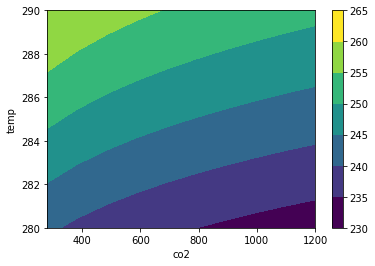

In [8]:
import xarray as xr
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, 10), 'co2':np.linspace(280, 1200, 10)})
da.plot.contourf()

# $dN = A  \, dlog(G)$

dN = olr-OLR0

therefore, dlogG = dG/G = dN/A

hence dG = G x dN/A ~ G x dN

In [28]:
%%time

TEMPS = np.linspace(280, 320, 41)
CO2_arr = np.zeros(len(TEMPS))

OLR0 = calc_olr(SST=288,CO2ppmv=280)

co2_init = 0

for idx,sst in enumerate(TEMPS):
    
    if idx==0:
        co2_trial=co2_init
        
    olr = calc_olr(SST=sst,CO2ppmv=co2_trial)
    
    imbalance = np.round(np.abs(olr-OLR0)[0],3)

    j=0
    while imbalance>0.2:
        
        if j==0:
            print('initial', int(sst), int(co2_trial), imbalance)
            j=1
       
        #dG = np.sign(olr-OLR0)*5.35
        dG = (np.sign(imbalance))
        co2_trial+=dG
        if co2_trial<0:
            co2_trial=0
            
        olr = calc_olr(SST=sst,CO2ppmv=co2_trial)
        
        imbalance = np.round(np.abs(olr-OLR0)[0],3)
    print('final',int(sst),int(co2_trial), imbalance)
    CO2_arr[idx] = int(co2_trial)

initial 280 0 13.545
final 280 8 0.116
initial 281 8 2.32
final 281 13 0.129
initial 282 13 2.278
final 282 21 0.176
initial 283 21 2.266
final 283 35 0.088
initial 284 35 2.123
final 284 55 0.195
initial 285 55 2.193
final 285 87 0.161
initial 286 87 2.101
final 286 131 0.175
initial 287 131 2.075
final 287 191 0.18
initial 288 191 2.043
final 288 270 0.199
initial 289 270 2.018
final 289 374 0.19
initial 290 374 1.966
final 290 506 0.192
initial 291 506 1.889
final 291 668 0.195
initial 292 668 1.828
final 292 863 0.199
initial 293 863 1.787
final 293 1094 0.198
initial 294 1094 1.735
final 294 1379 0.199
initial 295 1379 1.691
final 295 1725 0.199
initial 296 1725 1.645
final 296 2135 0.198
initial 297 2135 1.553
final 297 2598 0.2
initial 298 2598 1.517
final 298 3134 0.199
initial 299 3134 1.5
final 299 3759 0.199
initial 300 3759 1.447
final 300 4460 0.2
initial 301 4460 1.388
final 301 5229 0.2
initial 302 5229 1.168
final 302 5946 0.2
initial 303 5946 1.062
final 303 6656 0.2
i

Text(0.5, 0, 'T$_{s}$ (K)')

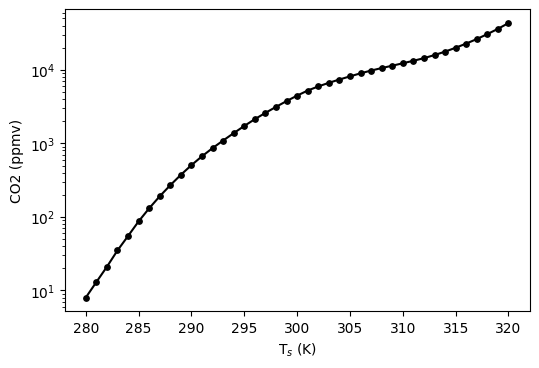

In [31]:
fig, ax = plt.subplots(dpi=100)

ax.plot(TEMPS, CO2_arr, 'k')
ax.scatter(TEMPS, CO2_arr, color='k', marker='o', s=15)

ax.set_yscale('log')

ax.set_ylabel("CO2 (ppmv)")
ax.set_xlabel(r"T$_{s}$ (K)")

## Calculate ECS 

$$\mathrm{ECS}(\mathrm{T_{s}}) = \mathrm{T_{s}}(2\mathrm{x CO}_{2}) - \mathrm{T_{s}}(\mathrm{CO}_{2})$$

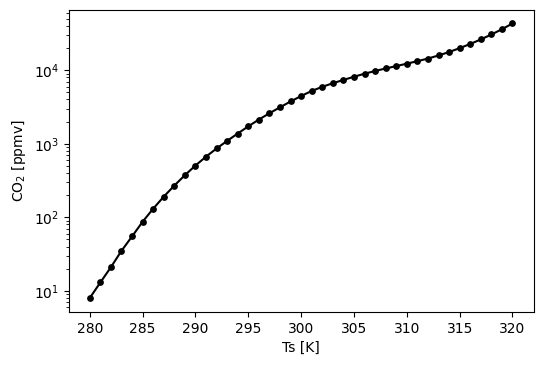

In [121]:
C_Ts = xr.DataArray(CO2_arr, dims=['Ts'], 
                    coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'})},
                    attrs={'standard_name': 'CO$_{2}$', 'units': 'ppmv'})
Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                    coords={'CO2':xr.DataArray(CO2_arr, dims=['CO2'], attrs={'units':'ppmv'})},
                    attrs={'standard_name': 'Ts', 'units': 'K'})

C_Ts.to_netcdf("./Data/C_Ts_curve_RRTMG.nc")
Ts_C.to_netcdf("./Data/Ts_C_curve_RRTMG.nc")

fig,ax=plt.subplots(dpi=100)
C_Ts.plot(ax=ax, yscale='log', color='k')
ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)

In [65]:
da_ECS = C_Ts.copy()
da_ECS.attrs = {'standard_name':'ECS', 'units': 'K'}
da_ECS

<xarray.DataArray (Ts: 41)>
array([8.0000e+00, 1.3000e+01, 2.1000e+01, 3.5000e+01, 5.5000e+01,
       8.7000e+01, 1.3100e+02, 1.9100e+02, 2.7000e+02, 3.7400e+02,
       5.0600e+02, 6.6800e+02, 8.6300e+02, 1.0940e+03, 1.3790e+03,
       1.7250e+03, 2.1350e+03, 2.5980e+03, 3.1340e+03, 3.7590e+03,
       4.4600e+03, 5.2290e+03, 5.9460e+03, 6.6560e+03, 7.3830e+03,
       8.1480e+03, 8.9620e+03, 9.7690e+03, 1.0569e+04, 1.1375e+04,
       1.2281e+04, 1.3270e+04, 1.4409e+04, 1.5880e+04, 1.7674e+04,
       1.9963e+04, 2.2753e+04, 2.6199e+04, 3.0600e+04, 3.6072e+04,
       4.3245e+04])
Coordinates:
  * Ts       (Ts) float64 280.0 281.0 282.0 283.0 ... 317.0 318.0 319.0 320.0
Attributes:
    standard_name:  ECS
    units:          K

In [122]:
for temp in da_ECS.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_ECS.loc[dict(Ts=temp)] = Ts_C.interp(CO2=2*conc) - Ts_C.sel(CO2=conc) 

da_ECS.to_netcdf("./Data/inferred_ECS_RRTMG.nc")

Text(0.5, 1.0, 'Inferred ECS')

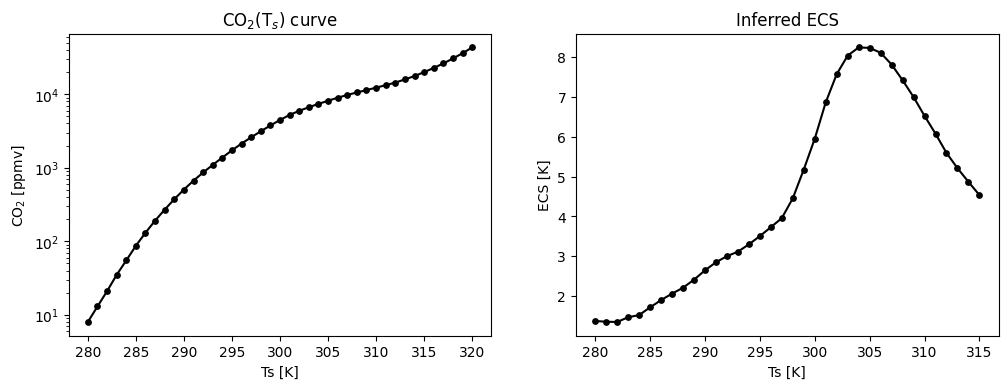

In [90]:
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_title(r"Inferred ECS")

In [95]:
Ts_ex = 307.
co2_ex = C_Ts.sel(Ts=Ts_ex).values
Ts_ex2=Ts_C.interp(CO2=2*co2_ex).values

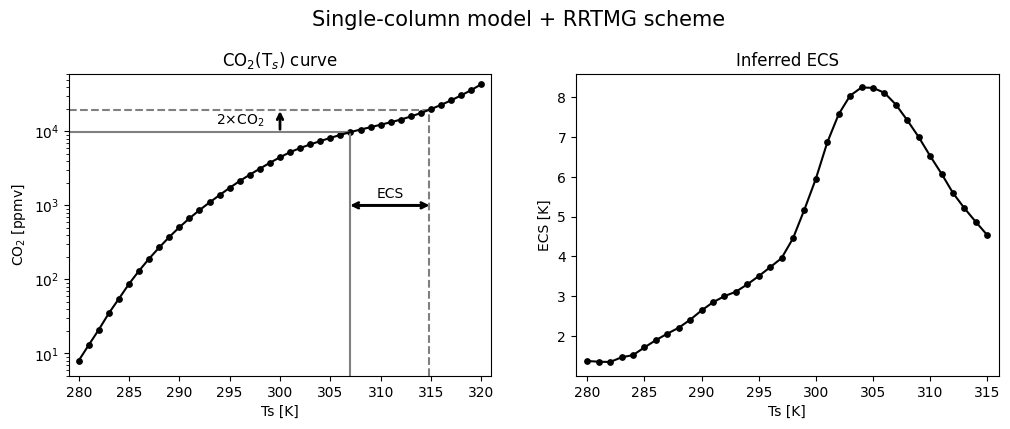

In [120]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 6e4
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

axs[0].plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axs[0].plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axs[0].plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axs[0].plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axs[0].annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(300, 2.1*co2_ex), xytext=(300, co2_ex),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))

axs[0].text(0.5*(Ts_ex+Ts_ex2),1.25e3,'ECS',ha='center')
axs[0].text(296,np.sqrt(co2_ex*2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center')

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_xlim(Tmin, Tmax)
axs[0].set_ylim(co2_min, co2_max)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_xlim(Tmin, 316)
axs[1].set_title(r"Inferred ECS")

fig.suptitle("Single-column model + RRTMG scheme", y=1.04, fontsize=15)

plt.savefig('Example_rrtmg_fig.png',bbox_inches='tight', dpi=200)

# Feed profiles through to PyRADS for spectrally-resolved OLR

In [155]:
import os
os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/RCE_bump')

In [174]:
os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/PyRADS/')
import pyrads
import numpy as np
from scipy.integrate import trapz,simps,cumtrapz

class Dummy:
    pass

params2 = Dummy()

params2.Rv = pyrads.phys.H2O.R # moist component
params2.cpv = pyrads.phys.H2O.cp
params2.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
params2.satvap_T0 = pyrads.phys.H2O.TriplePointT
params2.satvap_e0 = pyrads.phys.H2O.TriplePointP
params2.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,
                                                          params2.satvap_T0,
                                                          params2.satvap_e0,
                                                          params2.Rv,
                                                          params2.Lvap)

params2.R = pyrads.phys.air.R  # dry component
params2.cp = pyrads.phys.air.cp
params2.ps_dry = 1e5           # surface pressure of dry component

params2.g = 9.8             # surface gravity
params2.cosThetaBar = 3./5. # average zenith angle used in 2stream eqns
params2.RH = 0.8             # relative humidity

# setup resolution
N_press = 30
dwavenr = 0.1

wavenr_min = 0.1   # [cm^-1]
wavenr_max = 3500. #

Tstrat = 200.      # stratospheric temperature
Ts = 300.

# setup grid:
g = pyrads.SetupGrids.make_grid( Ts,Tstrat,N_press,wavenr_min,wavenr_max,dwavenr,params2, RH=params2.RH )

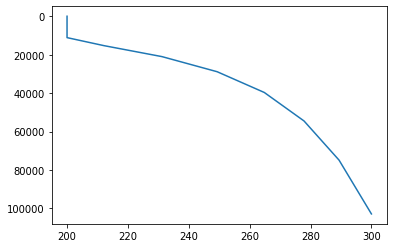

In [175]:
fig, ax = plt.subplots()

ax.plot(g.T, g.p)
ax.invert_yaxis()

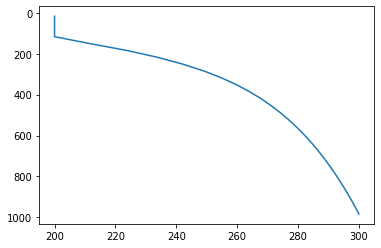

In [176]:
state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
plevs = state['Tatm'].domain.axes['lev'].points
temp = generate_idealized_temp_profile(300, params.Tstrat, plevs)

fig, ax = plt.subplots()

ax.plot(temp, plevs)
ax.invert_yaxis()

In [219]:
def calc_olr_pyrads(SST, CO2ppmv):
    ## PyRADS
    import os
    os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/PyRADS/')
    import pyrads
    import numpy as np
    from scipy.integrate import trapz,simps,cumtrapz

    class Dummy:
        pass

    params2 = Dummy()

    params2.Rv = pyrads.phys.H2O.R # moist component
    params2.cpv = pyrads.phys.H2O.cp
    params2.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
    params2.satvap_T0 = pyrads.phys.H2O.TriplePointT
    params2.satvap_e0 = pyrads.phys.H2O.TriplePointP
    params2.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,
                                                              params2.satvap_T0,
                                                              params2.satvap_e0,
                                                              params2.Rv,
                                                              params2.Lvap)

    params2.R = pyrads.phys.air.R  # dry component
    params2.R_CO2 = pyrads.phys.CO2.R
    params2.cp = pyrads.phys.air.cp
    params2.ps_dry = 1e5           # surface pressure of dry component

    params2.g = 9.8             # surface gravity
    params2.cosThetaBar = 3./5. # average zenith angle used in 2stream eqns
    params2.RH = 0.8             # relative humidity

    # setup resolution
    N_press = 30
    dwavenr = 0.1

    wavenr_min = 0.1   # [cm^-1]
    wavenr_max = 3500. #

    Tstrat = 200.      # stratospheric temperature
    Ts = 300.

    # setup grid:
    g = pyrads.SetupGrids.make_grid( Ts,Tstrat,N_press,wavenr_min,wavenr_max,dwavenr,params2, RH=params2.RH )

    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    temp = generate_idealized_temp_profile(SST, params.Tstrat, plevs)
    g.T = temp
    
    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    
    # compute optical thickness:
    g.tau = pyrads.OpticalThickness.compute_tau_H2ON2_CO2dilute(plevs, temp, h2o.q, 
                                                                CO2ppmv/1e6, g, 
                                                                params2, RH=params2.RH)
    # compute Planck functions etc:
    T_2D = np.transpose(np.tile( temp, (g.Nn,1) )) # shape=(g.p,g.n)
    g.B_surf = np.pi* pyrads.Planck.Planck_n( g.n, SST ) # shape=(g.n)
    g.B = np.pi* pyrads.Planck.Planck_n( g.wave, T_2D ) # shape=(g.p,g.n)
    # compute OLR etc:
    olr_spec = pyrads.Get_Fluxes.Fplus_alternative(0,g) # (spectrally resolved=irradiance)
    #olr = simps(olr_spec,g.n)
    #OLR_PyRADS[j,i] = olr
    #print(round(olr,2),end=", ")
    
    return olr_spec, g

In [220]:
C_Ts

<xarray.DataArray (Ts: 41)>
array([8.0000e+00, 1.3000e+01, 2.1000e+01, 3.5000e+01, 5.5000e+01,
       8.7000e+01, 1.3100e+02, 1.9100e+02, 2.7000e+02, 3.7400e+02,
       5.0600e+02, 6.6800e+02, 8.6300e+02, 1.0940e+03, 1.3790e+03,
       1.7250e+03, 2.1350e+03, 2.5980e+03, 3.1340e+03, 3.7590e+03,
       4.4600e+03, 5.2290e+03, 5.9460e+03, 6.6560e+03, 7.3830e+03,
       8.1480e+03, 8.9620e+03, 9.7690e+03, 1.0569e+04, 1.1375e+04,
       1.2281e+04, 1.3270e+04, 1.4409e+04, 1.5880e+04, 1.7674e+04,
       1.9963e+04, 2.2753e+04, 2.6199e+04, 3.0600e+04, 3.6072e+04,
       4.3245e+04])
Coordinates:
  * Ts       (Ts) float64 280.0 281.0 282.0 283.0 ... 317.0 318.0 319.0 320.0
Attributes:
    standard_name:  CO$_{2}$
    units:          ppmv

In [233]:
%%time
olr_spec1, g1 = calc_olr_pyrads(SST=282, CO2ppmv=22.3)
olr_spec2, g2 = calc_olr_pyrads(SST=283, CO2ppmv=22.3)

compute kappa at p,T =  16.666666666666668 200.0
compute kappa at p,T =  50.0 200.0
compute kappa at p,T =  83.33333333333334 200.0
compute kappa at p,T =  116.66666666666667 200.0
compute kappa at p,T =  150.0 200.0
compute kappa at p,T =  183.33333333333334 200.0
compute kappa at p,T =  216.66666666666666 200.0
compute kappa at p,T =  250.0 203.40004660568042
compute kappa at p,T =  283.33333333333337 210.76377969320333
compute kappa at p,T =  316.6666666666667 217.48810716043346
compute kappa at p,T =  350.00000000000006 223.65934699592484
compute kappa at p,T =  383.33333333333337 229.33693754574838
compute kappa at p,T =  416.6666666666667 234.56415345181344
compute kappa at p,T =  450.00000000000006 239.3756339560836
compute kappa at p,T =  483.33333333333337 243.80230887031948
compute kappa at p,T =  516.6666666666667 247.87410432239687
compute kappa at p,T =  550.0 251.62093649077153
compute kappa at p,T =  583.3333333333334 255.0725609365744
compute kappa at p,T =  616.6666666

In [234]:
da_olr_spec1 = xr.DataArray(olr_spec1, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g1.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

da_olr_spec2 = xr.DataArray(olr_spec2, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g2.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

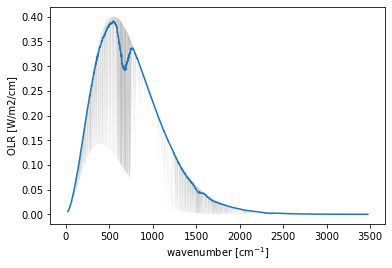

In [235]:
da_olr_spec1.plot(alpha=0.5, color='grey', lw=0.05)
da_olr_spec1.rolling(wavenumber=500, center=True).mean().plot()

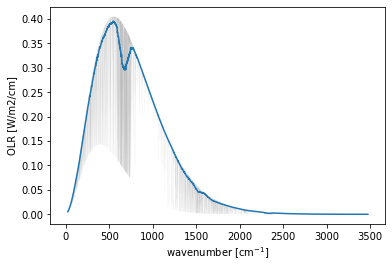

In [236]:
da_olr_spec2.plot(alpha=0.5, color='grey', lw=0.05)
da_olr_spec2.rolling(wavenumber=500, center=True).mean().plot()

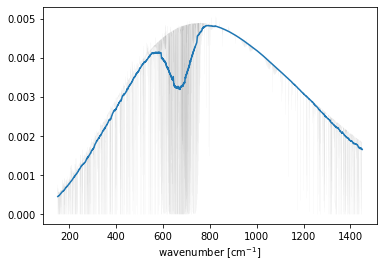

In [237]:
(da_olr_spec2-da_olr_spec1).sel(wavenumber=slice(150,1450)).plot(alpha=0.5, color='grey', lw=0.05)
(da_olr_spec2-da_olr_spec1).rolling(wavenumber=500, center=True).mean().sel(wavenumber=slice(150,1450)).plot()

## Column optical depth

(150.0, 1450.0)

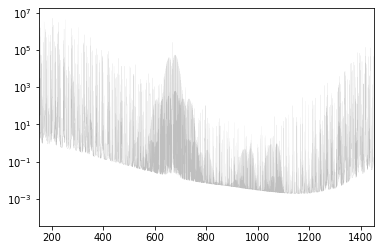

In [252]:
fig,ax=plt.subplots()

plt.plot(g1.n, np.sum(g1.tau, axis=0), alpha=0.5, color='grey', lw=0.1) 
plt.yscale('log')
plt.xlim(150,1450)

In [291]:
def vertical_integral(da):
    """
    n.b. Because of the way the data 
    is saved, it's easiest to do the 
    integral as:
    
    integral from p_top -> p_surf
    rather than the other way around (in screenshot)
    
    ---
    Also, to get vertical mean, divide by np.sum(plev)
    """
    
    assert 'plev' in da.dims
    
    #dx = np.gradient(da.plev)
    dx=xr.DataArray(np.gradient(da_.plev), dims=['plev'])
    dx[0] = 0.5 * dx[0]
    dx[-1] = 0.5 * dx[-1]
    F = (da*dx).sum('plev')
    
    if da.name is not None:
        F.name = "Column-integrated "+da.name
    
    return F/9.81

def column_mean(da):
    """
    n.b. Because of the way the data 
    is saved, it's easiest to do the 
    integral as:
    
    integral from p_top -> p_surf
    rather than the other way around (in screenshot)
    
    ---
    Also, to get vertical mean, divide by np.sum(plev)
    """
    
    assert 'plev' in da.dims
    
    #dx = np.gradient(da.plev)
    dx=xr.DataArray(np.gradient(da.plev), dims=['plev'])
    dx[0] = 0.5 * dx[0]
    dx[-1] = 0.5 * dx[-1]
    F = (da*dx).sum('plev')
    
    if da.name is not None:
        F.name = "Column-mean "+da.name
    
    return F/(dx.sum())

In [285]:
da_=xr.DataArray(g1.tau, dims=['plev', 'wavenumber'], 
             coords={'plev': xr.DataArray(plevs, dims=['plev']), 'wavenumber':g1.n})

In [292]:
column_mean(da_)

<xarray.DataArray (wavenumber: 34999)>
array([8.38711742e-06, 1.11318305e-05, 1.39079084e-05, ...,
       1.13097665e+01, 3.33561001e-03, 1.31883041e-04])
Coordinates:
  * wavenumber  (wavenumber) float64 0.1 0.2 0.3 0.4 ... 3.5e+03 3.5e+03 3.5e+03

(150.0, 1450.0)

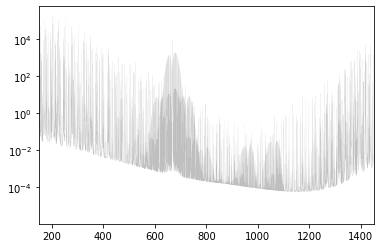

In [293]:
fig,ax=plt.subplots()

plt.plot(g1.n, column_mean(da_), alpha=0.5, color='grey', lw=0.1) 
plt.yscale('log')
plt.xlim(150,1450)